In [12]:
import pandas as pd
import numpy as np
import os
import cv2

from metods import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import image

from skimage.io import imread

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [29]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
PADDING = 40

models_folder = "models\\"

modelName = models_folder + "LungIdentifierModelDenseNet201.h5"

TRAINING_MODE = True
KAGGLE_MODE = False

healty_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty\\"
healty_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Mask\\"
healty_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Segmented\\"

pneu_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax\\"
pneu_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Mask\\"
pneu_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Segmented\\"

In [14]:
healty_segmented_images = os.listdir(healty_segmented_path)
pneu_segmented_images = os.listdir(pneu_segmented_path)

X_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images)), dtype=np.bool)

for i, img_id in enumerate(healty_segmented_images):
    file_name = healty_segmented_path + img_id

    img = readImages(file_name, is_gray=0)
    
    X_train[i] = img
    Y_train[i] = 0

for i, img_id in enumerate(pneu_segmented_images):
    file_name = pneu_segmented_path + img_id
    
    img = readImages(file_name, is_gray=0)
    
    X_train[len(healty_segmented_images) + i] = img
    Y_train[len(healty_segmented_images) + i] = 1

X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_train = X_train.reshape(-1, 128, 128, 3)

Y_train = to_categorical(Y_train)

print(X_train.shape)
print(Y_train.shape)

(12001, 128, 128, 3)
(12001, 2)


In [15]:
#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=8)

In [35]:
from tensorflow.keras.applications import DenseNet201

input_layer=layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model_DenseNet201=DenseNet201(weights='imagenet', input_tensor=input_layer, include_top=False)

last_layer=model_DenseNet201.output 

flatten=layers.Flatten()(last_layer) 

output_layer=layers.Dense(2, activation='softmax')(flatten)

model=models.Model(inputs=input_layer, outputs=output_layer)

for layer in model.layers[:-1]:
    layer.trainable=False

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/100
600/600 [==============================] - 28s 38ms/step - loss: 0.8867 - accuracy: 0.7814 - val_loss: 0.6908 - val_accuracy: 0.8596

Epoch 00001: val_accuracy improved from -inf to 0.85964, saving model to models\LungIdentifierModelDenseNet201.h5
Epoch 2/100
600/600 [==============================] - 21s 35ms/step - loss: 0.5260 - accuracy: 0.8577 - val_loss: 2.0766 - val_accuracy: 0.7168

Epoch 00002: val_accuracy did not improve from 0.85964
Epoch 3/100
600/600 [==============================] - 21s 35ms/step - loss: 0.6663 - accuracy: 0.8503 - val_loss: 1.0301 - val_accuracy: 0.8292

Epoch 00003: val_accuracy did not improve from 0.85964
Epoch 4/100
600/600 [==============================] - 21s 35ms/step - loss: 0.6057 - accuracy: 0.8642 - val_loss: 0.7432 - val_accuracy: 0.8392

Epoch 00004: val_accuracy did not improve from 0.85964

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/100
600/600 [==============================] - 2

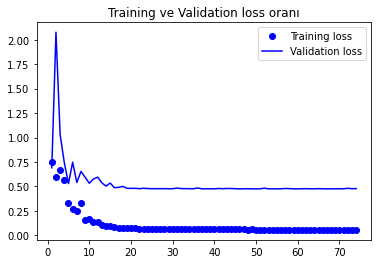

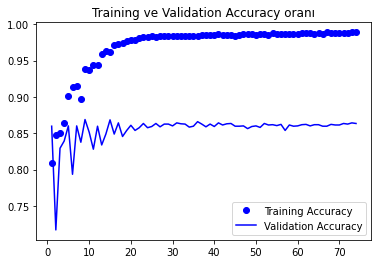

<Figure size 432x288 with 0 Axes>

In [36]:
if TRAINING_MODE:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    earlystopper = EarlyStopping(patience=25, verbose=1)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    checkpoint = ModelCheckpoint(modelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, learning_rate_reduction, earlystopper]

    history = model.fit(X_train/255.0, Y_train, validation_data=(X_test/255.0, Y_test), batch_size=16, epochs=100, callbacks=callbacks_list, shuffle=True)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training ve Validation loss oranı')
    plt.legend()
    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training ve Validation Accuracy oranı')
    plt.legend()
    plt.figure()
else:
    model = load_model(modelName)

In [32]:
model = load_model(modelName)

df_test = pd.DataFrame()

Y_test_normal = np.argmax(Y_test, axis=-1)

print(Y_test_normal.shape)

df_test['type'] = Y_test_normal

df_test = df_test.reset_index(drop=True)

df_test.head(10)

def fixImages(folder_name):
    for img_name in os.listdir(folder_name):
        try:
            readImages(folder_name + img_name)
        except Exception as ex:
            os.remove(folder_name + img_name)

(2401,)


In [33]:
preds = np.argmax(model.predict(X_test/255.0), axis=-1)

df_test['preds'] = np.round(preds)
df_test['preds'] = df_test['preds'].apply(np.int)

wrongs_df = df_test.loc[df_test['type'] != df_test['preds']]

print(f"Doğruluk oranı %{100 - (len(wrongs_df) * 100 / len(df_test))}")

df_test.head(10)

Doğruluk oranı %86.79716784673053


,type,preds
0,1,0
1,1,0
2,1,1
3,1,0
4,0,0
5,1,1
6,1,1
7,1,1
8,0,0
9,0,0


Accuracy :  0.8679716784673053
Sensitivity :  0.9125816993464052
Specificity :  0.8215802888700084


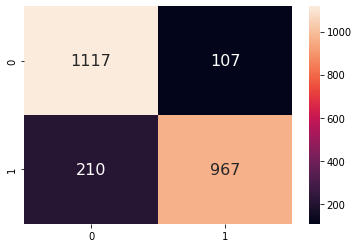

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm1 = confusion_matrix(df_test[['type']], df_test['preds'])
sn.heatmap(cm1, annot=True, annot_kws={"size": 16}, fmt="d")

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)




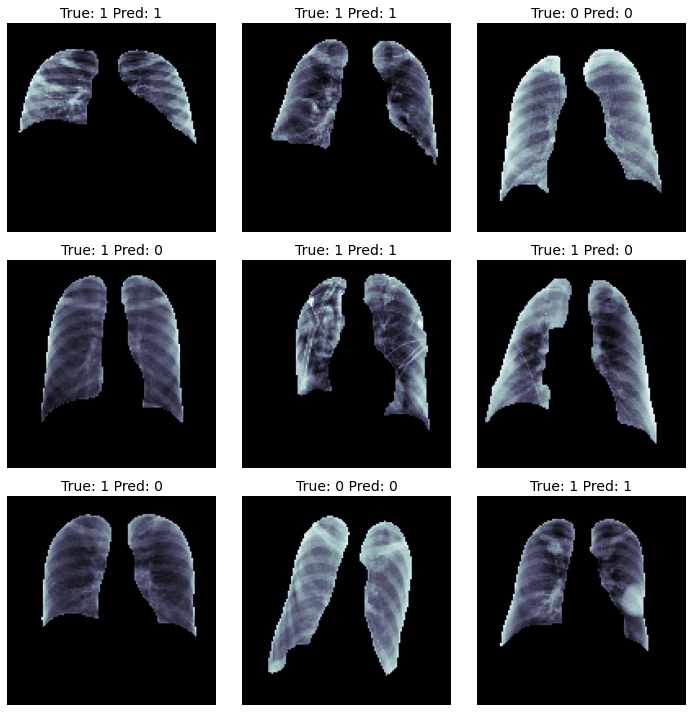

In [28]:
plt.figure(figsize=(10,10))
plt.axis('Off')

start_from = 10

for i in range(1, 10):
    plt.subplot(3,3,i)
    test_image = X_test[i + start_from, :, :, 0]
    plt.imshow((test_image), cmap=plt.cm.bone)

    true = df_test.loc[i + start_from, 'type']
    pred = df_test.loc[i + start_from, 'preds']
    result = 'True: ' + str(int(true)) + ' Pred: ' + str(pred)

    plt.title(result, fontsize=14)
    plt.axis('off')


plt.tight_layout()
plt.show()